In [1]:
# The cities are represented as indices: A=0, B=1, C=2, D=3
distances = [
    [0, 10, 15, 20],
    [10, 0, 35, 25],
    [15, 35, 0, 30],
    [20, 25, 30, 0]
]


In [2]:
import itertools

cities = [1, 2, 3]  # We exclude the first city (0)

# Generate all permutations of cities
routes = list(itertools.permutations(cities))

# Add the first city to the start and end of each route
routes = [(0,) + route + (0,) for route in routes]


In [3]:
shortest_route = None
shortest_distance = None

for route in routes:
    distance = sum(distances[i][j] for i, j in zip(route, route[1:]))
    
    if shortest_distance is None or distance < shortest_distance:
        shortest_route = route
        shortest_distance = distance

print("The shortest route is:", shortest_route)
print("The total distance of this route is:", shortest_distance)


The shortest route is: (0, 1, 3, 2, 0)
The total distance of this route is: 80


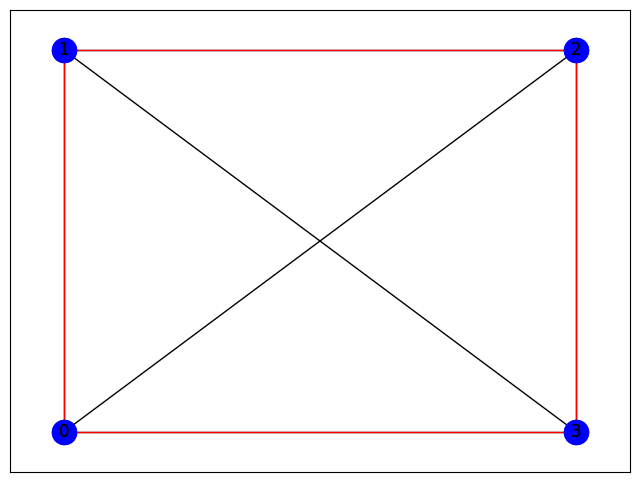

In [11]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def get_subtour(edges):
    nodes = set([edges[0][0]])
    while True:
        new_nodes = set([j for i in nodes for j, val in edges if val == 1 and i == j])
        nodes |= new_nodes
        if len(new_nodes) == 0:
            break
    return list(nodes)

# Load data from CSV
data = pd.read_csv('coordinates.csv')
coordinates = list(zip(data['x'], data['y']))

# Number of cities
num_cities = len(coordinates)

# Create a fully connected graph
G = nx.complete_graph(num_cities)

# Compute distances between cities and add them as weights to the edges
for i in range(num_cities):
    for j in range(i+1, num_cities):
        G[i][j]['weight'] = ((coordinates[i][0]-coordinates[j][0])**2 + (coordinates[i][1]-coordinates[j][1])**2)**0.5

# Define the problem
prob = pulp.LpProblem('TSP', pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts('x', G.edges(), cat='Binary')

# Objective function
prob += pulp.lpSum([G.edges[e]['weight']*x[e] for e in G.edges()])

# Constraints
for i in G.nodes():
    prob += pulp.lpSum([x[tuple(sorted((i,j)))] for j in G.neighbors(i)]) == 2, f'degree_constraint_{i}'

while True:
    prob.solve()

    edges = [(i,j) for i,j in G.edges() if pulp.value(x[(i,j)]) == 1]

    subtour = get_subtour(edges)
    if len(subtour) == num_cities:  # If the subtour includes all cities, we have found an optimal tour
        break

    # Add a constraint to forbid the current subtour
    prob += pulp.lpSum([x[tuple(sorted((i,j)))] for i in subtour for j in subtour if i != j]) <= len(subtour) - 1

# Extract the optimal tour
opt_tour = [e for e in G.edges() if pulp.value(x[e]) == 1]

# Determine the sequence of cities
opt_tour_sorted = sorted(opt_tour, key=lambda x: data['city'][x[0]])

# Convert city indices to city names and save to CSV
opt_cities = [data['city'][i] for i,j in opt_tour_sorted]
opt_cities.append(opt_cities[0])  # append the first city at the end to complete the cycle
pd.DataFrame(opt_cities, columns=['city']).to_csv('optimal_tour.csv', index=False)

# Visualize the tour
pos = {i: coord for i, coord in enumerate(coordinates)}
opt_G = nx.Graph()
opt_G.add_edges_from(opt_tour)
plt.figure(figsize=(8,6))
nx.draw_networkx(G, pos=pos, node_color='blue')
nx.draw_networkx(opt_G, pos=pos, edge_color='red', node_color='blue')
plt.show()


: 

: 

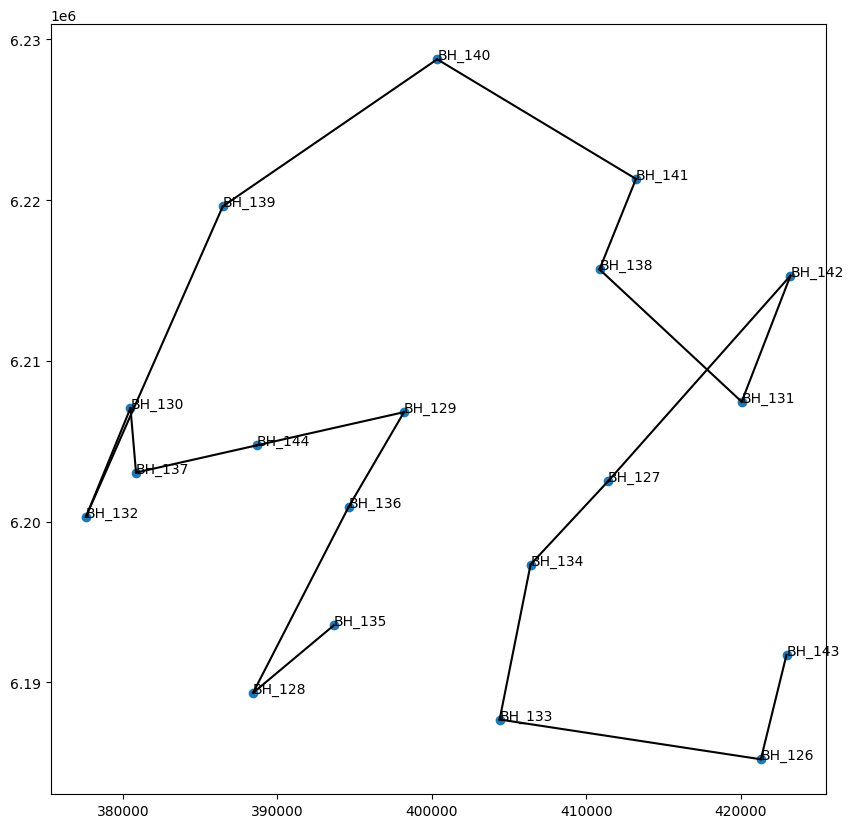

In [18]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('cities.csv', header=None, names=['city', 'x', 'y'])

# Prompt user for current city
current_city = input("Please enter your current city (press enter to use the first city in the list): ")

# If no city is entered, use the first city in the list
if current_city == '':
    current_city = df.iloc[0]['city']
# If a city is entered, validate input
elif current_city not in df['city'].values:
    raise ValueError("Invalid city. Make sure it's one of the cities in the dataset.")

# Calculate distance matrix
distances = distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values)
dist_matrix = pd.DataFrame(distances, index=df.city, columns=df.city)

# Create graph
G = nx.from_numpy_array(dist_matrix.values.astype(float))

# Get index of current city
source_index = df[df['city'] == current_city].index[0]

# Find shortest path
tsp_route = nx.approximation.greedy_tsp(G, source=source_index)

# Get city names
route = [(df.iloc[i]['city'], df.iloc[i]['x'], df.iloc[i]['y']) for i in tsp_route]

# Remove last city to make it one way
route_one_way = route[:-1]

# Save result
with open('route.txt', 'w') as f:
    for city, x, y in route_one_way:
        f.write(f'{city}, {x}, {y}\n')

# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(df['x'], df['y'])

# Add labels
for _, row in df.iterrows():
    plt.text(row['x'], row['y'], row['city'])

prev_node = tsp_route[0]
for node in tsp_route[1:-1]:  # stop one city before the end
    plt.plot([df.iloc[prev_node]['x'], df.iloc[node]['x']], [df.iloc[prev_node]['y'], df.iloc[node]['y']], 'k-')
    prev_node = node
plt.show()


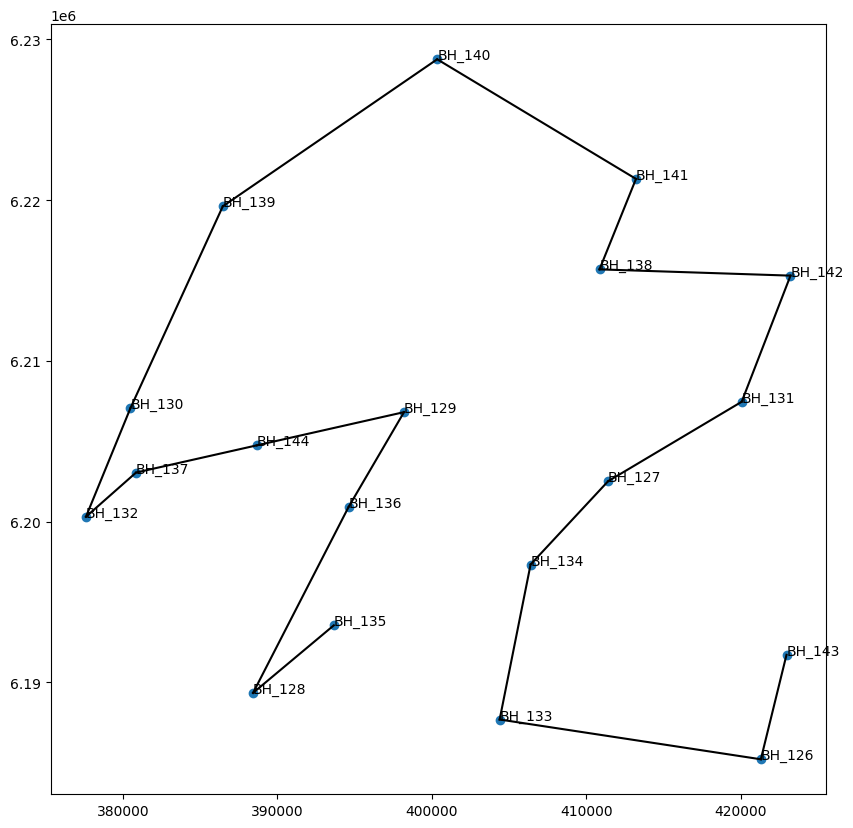

In [19]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Load data
df = pd.read_csv('cities.csv', header=None, names=['city', 'x', 'y'])

# Prompt user for current city
current_city = input("Please enter your current city (leave empty and press enter to use the first city in the list): ")

# If no city is entered, use the first city in the list
if current_city == '':
    current_city = df.iloc[0]['city']
# If a city is entered, validate input
elif current_city not in df['city'].values:
    raise ValueError("Invalid city. Make sure it's one of the cities in the dataset.")

# Calculate distance matrix
distances = distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values)
dist_matrix = pd.DataFrame(distances, index=df.city, columns=df.city)

# Create graph
G = nx.from_numpy_array(dist_matrix.values.astype(float))

# Get index of current city
source_index = df[df['city'] == current_city].index[0]

# Find initial path
tsp_route = nx.approximation.greedy_tsp(G, source=source_index)

# 2-opt algorithm
for _ in range(50):  # Run for a fixed number of iterations
    for i, j in combinations(range(1, len(tsp_route) - 1), 2):  # For each pair of edges in the path
        if i != j:
            new_route = tsp_route[:i] + tsp_route[i:j][::-1] + tsp_route[j:]  # Try reversing the path between i and j
            if sum(dist_matrix.values[new_route[i], new_route[i - 1]] for i in range(1, len(new_route))) < sum(
                    dist_matrix.values[tsp_route[i], tsp_route[i - 1]] for i in range(1, len(tsp_route))):  # If the new path is shorter
                tsp_route = new_route  # Update the path

# Get city names
route = [(df.iloc[i]['city'], df.iloc[i]['x'], df.iloc[i]['y']) for i in tsp_route]

# Remove last city to make it one way
route_one_way = route[:-1]

# Save result
with open('route.txt', 'w') as f:
    for city, x, y in route_one_way:
        f.write(f'{city}, {x}, {y}\n')

# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(df['x'], df['y'])

# Add labels
for _, row in df.iterrows():
    plt.text(row['x'], row['y'], row['city'])

prev_node = tsp_route[0]
for node in tsp_route[1:-1]:  # stop one city before the end
    plt.plot([df.iloc[prev_node]['x'], df.iloc[node]['x']], [df.iloc[prev_node]['y'], df.iloc[node]['y']], 'k-')
    prev_node = node
plt.show()
